In [1]:
# Проверка возможности использования xgbooster - объединение JPG & TIF (2017-07-03)

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
import xgboost as xgb

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [7]:
binsData = 75

trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
if False : # True :
    trDirI = trDirJPG
    teDirI = teDirJPG
    ttExt  = '.jpg'
else :
    trDirI = trDirTIF
    teDirI = teDirTIF
    ttExt  = '.tif'
trWork, teWork = '../Work/Train', '../Work/Test'
print (trDirI,teDirI, trWork, teWork)
print (trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG)

../Data/train-tif-v2 ../Data/test-tif-v2 ../Work/Train ../Work/Test
../Data/train_v2.csv ../Data/train-tif-v2 ../Data/train-jpg ../Data/test-tif-v2 ../Data/test-jpg-v2


In [67]:
binsDataTIF = 96
binsDataJPG = 96

In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add features (0 or 1) for every label as dataframe field 
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#labels_df.head()

In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
#labelList[:6,:]
#labels_df.head()

In [164]:
# Данные для объединения от jpg
binsDataJPG2 = 64
trX_TIF  = np.load('../Work/train-data-XX'+str(binsDataTIF)+'.tif'+'.npy')
trX_JPG  = np.load('../Work/train-data-XX'+str(binsDataJPG)+'.jpg'+'.npy')
trX_JPG2 = np.load('../Work/train-data-XX'+str(binsDataJPG2)+'.jpg'+'.npy')
trY      = np.load('../Work/train-data-YY'+str(binsDataTIF)+'.tif'+'.npy')
trX_TIF.shape, trX_JPG.shape

((40479, 578), (40479, 255))

In [165]:
578/6, 255/3, 96+96+96

(96, 85, 288)

In [166]:
## Обрезка видимой части и использование только n, nvi, dwi
##trX_TIF = trX_TIF[:,288:]

In [167]:
##trX_TIF.shape, 290/3

In [168]:
trXX = np.hstack([trX_JPG,trX_JPG2,trX_TIF])
trX  = trXX
print (trX.shape,trX_TIF.shape,trX_JPG.shape,trY.shape)
del trXX,trX_JPG,trX_TIF,trX_JPG2

(40479, 1025) (40479, 578) (40479, 255) (40479, 17)


In [169]:
# Строим основные массивы
dtrain = xgb.DMatrix(trX,label=trY[:,0])

In [170]:
# Построение списка bst - моделей
def getListBST (param, trX, trY, nfold=3, early_stop=20) :
    dtrain = xgb.DMatrix(trX,label=trY[:,0])
    results, bstList = [], []
    for i in range(trY.shape[1]) :
        print ('Working: {}'.format(i))
        dtrain.set_label(trY[:,i])
        history = xgb.cv(param, dtrain, metrics=['auc'], 
                         verbose_eval=30, num_boost_round=5000, nfold=nfold, 
                         early_stopping_rounds=early_stop)
        results.append(history)
        rvalidCV, watchlistCV = {}, [(dtrain,'train')]
        bst = xgb.train(param, dtrain, history['test-auc-mean'].argmax()+1, watchlistCV) 
        bstList.append(bst)
    return(bstList)

# Построение решения по dmatrix и bst списку
def buildPredict (dData, bstList) :
    trYP = []
    for bstI in bstList :
        trYP1 = bstI.predict(dData); trYP.append(trYP1)
    trYP = np.array(trYP).T
    #type(trYP),trYP.shape
    return(trYP)

# Построение решения по np.array (DataFrame?) и bst списку
def buildPredictX (Data, bstList) :
    dData = xgb.DMatrix(Data);
    return (buildPredict(dData,bstList))

In [171]:
# Процедуры для оценки результативности

def getConfusion (tGroundTrue, tPredict) :
    cList = []
    for i in range(tPredict.shape[1]) :
        cList.append(skm.confusion_matrix(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(cList))

def getRocAUC (tGroundTrue, tPredict) :
    rList = []
    for i in range(tPredict.shape[1]) :
        rList.append(skm.roc_auc_score(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(rList))

In [172]:
# Оценка нескольких наборов
def getProb01 (trYP, th=0.5) :
    trYY = trYP.copy()
    trYY[trYY<th] = 0
    trYY[trYY>0]  = 1
    return (trYY)

def estimateTrain (estimateList, param) :
    res = []
    for jpgtif, bins in estimateList :
        trX     = np.load('../Work/train-data-XX'+str(bins)+jpgtif+'.npy')
        trY     = np.load('../Work/train-data-YY'+str(bins)+jpgtif+'.npy')
        listBST = getListBST(param, trX, trY)
        trYP    = buildPredictX(trX,listBST)
        trYY    = getProb01(trYP)
        res.append(np.array(getConfusion(trY,trYY)))
    return(res)      

In [173]:
param = {
         'objective':'reg:logistic', 
         #'num_class':17,
         #'eta':0.05, 
         #'max_depth':9, 'subsample':0.8, 'colsample_bytree':0.8, 
         #'metrics':'rmse'
         'eval_metric':['auc','rmse']
        }
param['silent']=True

In [71]:
#xJPG = estimateTrain([('.jpg',32),('.jpg',64),('.jpg',96)],param)
%time

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs


In [64]:
#xJPG
for cms in xJPG :
    cm = cms[:,0,1]+cms[:,1,0]
    print (cm.sum(),cms[:,0,1]+cms[:,1,0])
%time

19743 [1224  629 3295  576 4277 1799 2939 3338  206   13  408    0  433   13  234
  324   35]
18538 [1248   90 3625 1106 2927 1603 3518 2655  194   38  233    0  658    0  264
  303   76]
15592 [1338  470 2304  551 2569 1136 3111 2691  168  143   18   24  532    0  269
  227   41]
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [72]:
#xTIF = estimateTrain([('.tif',32),('.tif',64),('.tif',96)],param)
%time

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs


In [66]:
for cms in xTIF :
    cm = cms[:,0,1]+cms[:,1,0]
    print (cm.sum(),cms[:,0,1]+cms[:,1,0])
%time

23842 [1438 1001 3107 1913 3395 1967 4088 3460  188  413 1761   17  492    6  197
  301   98]
21119 [1015  864 3257  846 3520 1771 3654 3382  149  369  994   54  654    9  198
  304   79]
17984 [ 874  783 2743  732 3002 1824 3533 3074   57   99  146    0  658   24  303
   53   79]
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


In [174]:
# Считаем
bstList = getListBST(param,trX,trY)

Working: 0
[0]	train-auc:0.946314+0.00407778	test-auc:0.930789+0.00535691
[30]	train-auc:0.99154+0.000659668	test-auc:0.962568+0.00190678
[0]	train-auc:0.943631	train-rmse:0.377497
[1]	train-auc:0.957915	train-rmse:0.300397
[2]	train-auc:0.964023	train-rmse:0.249734
[3]	train-auc:0.966964	train-rmse:0.218373
[4]	train-auc:0.969765	train-rmse:0.197408
[5]	train-auc:0.9709	train-rmse:0.185614
[6]	train-auc:0.9725	train-rmse:0.17812
[7]	train-auc:0.974162	train-rmse:0.172927
[8]	train-auc:0.975828	train-rmse:0.169856
[9]	train-auc:0.976373	train-rmse:0.167806
[10]	train-auc:0.977679	train-rmse:0.165808
[11]	train-auc:0.978409	train-rmse:0.164608
[12]	train-auc:0.978947	train-rmse:0.162909
[13]	train-auc:0.981103	train-rmse:0.160239
[14]	train-auc:0.981699	train-rmse:0.159144
[15]	train-auc:0.982709	train-rmse:0.157793
[16]	train-auc:0.983189	train-rmse:0.156856
[17]	train-auc:0.983745	train-rmse:0.155944
[18]	train-auc:0.984054	train-rmse:0.155151
[19]	train-auc:0.984512	train-rmse:0.1545

In [175]:
# Шаблоны имен файллов для сохранения моделей xgb
fModel1 = '../Work/Models/model-'
fModel2 = '-jpg-'+str(binsDataJPG)+'--tif-'+str(binsDataTIF)+'.xgb'

In [176]:
# save xgb models into files
for i in range(len(bstList)) :
    bstList[i].save_model(fModel1+str(100+i)+'-JPG2'+fModel2)

In [615]:
# load xgb models into files
bstNull = xgb.train(param,dtrain,0)
bstList0= []
for i in range(trY.shape[1]) :
    bstList0.append(bstNull.copy())
    bstList0[-1].load_model(fModel1+str(100+i)+fModel2)
bstList = bstList0
del bstList0
len(bstList)

17

In [177]:
trYP = buildPredict(dtrain,bstList)
trYPP= trYP.copy() # вероятностный массив
trYP[trYP<0.5] = 0 # массив 0/1
trYP[trYP!=0]  = 1
print (trYP.shape, '\n', trYPP[0], '\n', trYP[0])

(40479, 17) 
 [  7.79969871e-01   9.97929573e-01   7.15023978e-03   1.10026486e-02
   1.49513399e-02   1.38273812e-03   5.87781053e-03   4.98477835e-03
   3.02072567e-05   4.36046248e-04   1.73015418e-04   2.89217533e-05
   5.07971644e-03   1.61501237e-06   2.22017220e-03   7.13975925e-04
   6.16241523e-05] 
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [178]:
accListOld = accList

In [179]:
# Оценка точности предсказания по train массиву по разным методикам
accList = []
for i in range(trYP.shape[1]) :
    print ('#{} accuracy={} precision={} recall={} ros_auc={} fbeta2={} not={}'.format(i, 
                                           skm.accuracy_score(trY[:,i],trYP[:,i]), 
                                           skm.precision_score(trY[:,i],trYP[:,i]), 
                                           skm.recall_score(trY[:,i],trYP[:,i]), 
                                           skm.roc_auc_score(trY[:,i],trYP[:,i]), 
                                           skm.fbeta_score(trY[:,i],trYP[:,i],beta=2),
                                           len(trYP[trYP[:,i]<>trY[:,i],i])))
    accList.append((i, skm.roc_auc_score(trY[:,i],trYP[:,i]), skm.confusion_matrix(trY[:,i],trYP[:,i])))
    #fpr,tpr,thr = skm.roc_curve(trY[:,i],trYP[:,i]); print (len(thr),len(fpr),len(trYP[:,i]))
    #plt.plot(fpr,tpr); plt.show()

#0 accuracy=0.975616986586 precision=0.881016042781 recall=0.733036707453 ros_auc=0.86298492511 fbeta2=0.758517495396 not=987
#1 accuracy=0.999160058302 precision=0.999600095977 recall=0.999493508917 ros_auc=0.997218096333 fbeta2=0.99951482451 not=34
#2 accuracy=0.943131006201 precision=0.924459516744 recall=0.885424279334 ros_auc=0.926894074051 fbeta2=0.892965359102 not=2302
#3 accuracy=0.994515674794 precision=0.994391671632 recall=0.99781928177 ros_auc=0.992269534643 fbeta2=0.997131870681 not=222
#4 accuracy=0.925936905556 precision=0.89864498645 recall=0.671164485225 ros_auc=0.827099721746 fbeta2=0.706955854345 not=2998
#5 accuracy=0.960572148521 precision=0.889433962264 recall=0.643989071038 ros_auc=0.818015611594 fbeta2=0.681607865818 not=1596
#6 accuracy=0.941352306134 precision=0.896340614999 recall=0.798166274315 ros_auc=0.887589061621 fbeta2=0.816042157533 not=2374
#7 accuracy=0.943847427061 precision=0.919969512195 recall=0.539200357382 ros_auc=0.766683674052 fbeta2=0.587862

In [180]:
# сравнение текущего и предыдущего результата если есть
#if accListOld is not None :
[(i,cm[0,1]+cm[1,0],(accList[i][2][1,0]+accListOld[i][2][0,1]),
  cm[0,1]+cm[1,0]-(accList[i][2][1,0]+accListOld[i][2][0,1])) for i,roc,cm in accList]

[(0, 987, 1048, -61),
 (1, 34, 188, -154),
 (2, 2302, 2345, -43),
 (3, 222, 574, -352),
 (4, 2998, 2953, 45),
 (5, 1596, 1546, 50),
 (6, 2374, 2509, -135),
 (7, 2273, 2324, -51),
 (8, 0, 0, 0),
 (9, 17, 15, 2),
 (10, 0, 0, 0),
 (11, 0, 0, 0),
 (12, 498, 496, 2),
 (13, 0, 0, 0),
 (14, 243, 243, 0),
 (15, 246, 247, -1),
 (16, 5, 5, 0)]

In [181]:
wr = [labels.index(i) for i in weather_labels]; wr
print(labels)
trYPP[trYPP[:,wr].argmax(axis=1)<>trY[:,wr].argmax(axis=1)].shape, wr, (40497.0-498)/40497.0, (40497.0-898)/40497.0

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


((352, 17), [3, 10, 0, 9], 0.9877027927994666, 0.9778255179396005)

In [182]:
# Построение значимости полей для разных признаков (importance)
bstga   = np.zeros((trX.shape[1],trY.shape[1]))
for i in range(len(bstList)) :
    bstgfs = bstList[i].get_fscore()
    bstgfs = [(int(n.split('f')[1]),bstgfs[n]) for n in bstgfs.keys()]
    bstga1 = np.array(bstgfs)
    bstga[bstga1[:,0],i] = bstga1[:,1]


if False :
    #bstgfs.sort(key=lambda x: -x[1])
    #bstgfs[:20]
    plt.hist([nn for n,nn in bstgfs],bins=11); plt.show()
    bst_gfs_main = [(n,nn) for n,nn in bstgfs if nn>=20]
    bst_gfs_main.sort(key=lambda x: x[0])
    bst_gfs_main
    bstga[:,6]

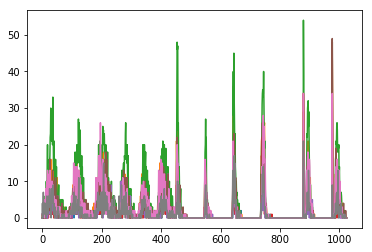

['haze',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'bare_ground']

In [183]:
xx = [0]+range(2,8)+[12] # плохие 600-4000
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


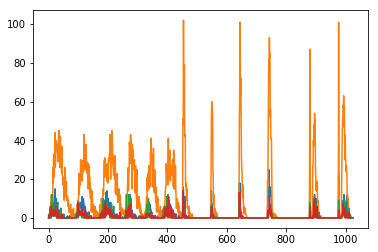

['slash_burn', 'partly_cloudy', 'blooming', 'selective_logging']

In [184]:
xx = [8,10,14,15] # среднии 100-400
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


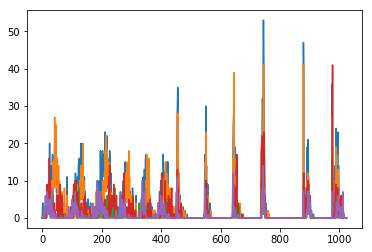

['primary', 'cloudy', 'conventional_mine', 'artisinal_mine', 'blow_down']

In [185]:
xx = [1,9,11,13,16] # отличные 0-100
plt.plot(bstga[:,xx]); plt.show();
[labels[x] for x in xx]

In [187]:
# Посчитать уровень прохождения для каждого признака

In [188]:
ixx,iacc = [], []
for i in range(trY.shape[1]) :
    max, maxxx = 0.0, 0.0
    for xx in range(0,101) :
        tempYP = trYPP[:,i].copy(); #print(tempYP.mean())
        tempYP[tempYP<float(xx/100.0)] = 0
        tempYP[tempYP>0.0]   = 1
        temp = skm.accuracy_score(trY[:,i],tempYP)
        #print(float(xx/10.0),temp)
        if (temp>max) : 
            max = temp; maxxx = float(xx)
            temp = skm.confusion_matrix(trY[:,i],tempYP);
            minloss = temp[0][1]+temp[1][0]
    ixx.append(maxxx)
    tempYP = trYPP[:,i].copy(); #print(tempYP.mean())
    tempYP[tempYP<0.5]   = 0
    tempYP[tempYP>0.0]   = 1
    temp = skm.accuracy_score(trY[:,i],tempYP)
    minloss05 = skm.confusion_matrix(trY[:,i],tempYP);
    minloss05 = minloss05[0][1]+minloss05[1][0]
    iacc.append((maxxx,max,temp,minloss,minloss05))
ixx
#[ixx[xx] for xx in wr]

[44.0,
 48.0,
 43.0,
 57.0,
 40.0,
 41.0,
 44.0,
 34.0,
 11.0,
 44.0,
 9.0,
 8.0,
 27.0,
 5.0,
 21.0,
 23.0,
 16.0]

In [190]:
iacc

[(44.0, 0.97667926579213915, 0.975616986585637, 944, 987),
 (48.0, 0.99928357913980093, 0.99916005830183552, 29, 34),
 (43.0, 0.9449097062674473, 0.94313100620074608, 2230, 2302),
 (57.0, 0.99493564564342007, 0.99451567479433778, 205, 222),
 (40.0, 0.92860495565601919, 0.9259369055559673, 2890, 2998),
 (41.0, 0.96321549445391441, 0.96057214852145556, 1489, 1596),
 (44.0, 0.94364979372020064, 0.94135230613404486, 2281, 2374),
 (34.0, 0.95582894834358556, 0.94384742706094515, 1788, 2273),
 (11.0, 1.0, 1.0, 0, 0),
 (44.0, 0.99958002915091781, 0.99958002915091781, 17, 17),
 (9.0, 1.0, 1.0, 0, 0),
 (8.0, 1.0, 1.0, 0, 0),
 (27.0, 0.99157587885076215, 0.98769732453864967, 341, 498),
 (5.0, 1.0, 1.0, 0, 0),
 (21.0, 0.99594851651473604, 0.99399688727488322, 164, 243),
 (23.0, 0.99614614985548067, 0.993922774772104, 156, 246),
 (16.0, 1.0, 0.99987647916203459, 0, 5)]

In [191]:
# Forming output dataset for predicting --> trOX, trOY
#del(trX)
#del(trY)

In [192]:
# Данные для объединения от jpg
trOX_TIF = np.load('../Work/test-data-XX'+str(binsDataTIF)+'.tif'+'.npy')
trOX_JPG1 = np.load('../Work/test-data-XX'+str(binsDataJPG)+'.jpg'+'.npy')
trOX_JPG2 = np.load('../Work/test-data-XX'+str(binsDataJPG2)+'.jpg'+'.npy')
trOY_TIF = np.load('../Work/test-data-YY'+str(binsDataTIF)+'.tif'+'.npy')
trOY_JPG1 = np.load('../Work/test-data-YY'+str(binsDataJPG)+'.jpg'+'.npy')
trOY_JPG2 = np.load('../Work/test-data-YY'+str(binsDataJPG2)+'.jpg'+'.npy')

In [198]:
trOX_TIF.shape, trOX_JPG.shape, trOX_JPG2.shape , 578+255+192

((61191, 578), (61191, 255), (61191, 192), 1025)

In [195]:
# Обрезка видимой части и использование только n, nvi, dwi
##trOX_TIF = trOX_TIF[:,288:]
##trOX_TIF.shape

In [199]:
# Аккуратно объединяем через индексы = имена файлов
dfOX_TIF  = pd.DataFrame(trOX_TIF,index=trOY_TIF)
dfOX_JPG1 = pd.DataFrame(trOX_JPG,index=trOY_JPG1)
dfOX_JPG2 = pd.DataFrame(trOX_JPG2,index=trOY_JPG2)

dfOX_JPG  = dfOX_JPG1.join(dfOX_JPG2,lsuffix='_l',rsuffix='_r')

dfOX = dfOX_JPG.join(dfOX_TIF,lsuffix='_l',rsuffix='_r')

dfOX.shape #, dfOX.columns,dfOX.head()

(61191, 1025)

In [200]:
trOX = dfOX.values
trOY = dfOX.index.values
trOX.shape,trOY.shape,trOY[0:10]

((61191, 1025),
 (61191,),
 array(['test_10002', 'test_10003', 'test_10004', 'test_10005',
        'test_10006', 'test_10007', 'test_10008', 'test_10009', 'test_1001',
        'test_10010'], dtype=object))

In [156]:
# Формирование результата
dtest  = xgb.DMatrix(trOX)

In [157]:
trP = []
for bstI in bstList :
    trP1 = bstI.predict(dtest);
    trP.append(trP1)
trP = np.array(trP).T
type(trP),trP.shape    

(numpy.ndarray, (61191, 17))

In [158]:
#np.save('../Work/test-data-RR'+str(binsData)+ttExt+'.npy',trP)

In [201]:
#trP = np.load('../Work/test-data-RR'+str(binsData)+ttExt+'.npy')
#trP.shape

In [202]:
wr = [labels.index(i) for i in weather_labels];
trM=np.array(ixx)/100.0 #np.array([0.5]*17);
#### Коэффициенты работают +0.01 к счету trM=np.array([0.5]*17);
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.48, 0.43, 2.0, 0.4, 0.41, 0.44, 0.34, 0.11, 2.0, 2.0, 0.08, 0.27, 0.05, 0.21, 0.23, 0.16]


In [203]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trA1 = [weather_labels[trP[i,wr].argmax()]]
    trA2 = [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])]
    trPP = trA1 + trA2;
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.    0.48  0.43  2.    0.4   0.41  0.44  0.34  0.11  2.    2.    0.08
  0.27  0.05  0.21  0.23  0.16] [  6.24508783e-02   2.45814770e-01   4.45817411e-02   4.16464716e-01
   5.03526151e-01   3.26644303e-03   1.00426078e-02   1.05248787e-03
   2.95093923e-06   5.92517912e-01   3.07402515e-05   1.12990097e-06
   1.18690729e-03   1.24388123e-06   1.84289253e-04   1.92705193e-04
   2.77233212e-05]


In [204]:
print(labels)
print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']
[2.0, 0.48, 0.43, 2.0, 0.4, 0.41, 0.44, 0.34, 0.11, 2.0, 2.0, 0.08, 0.27, 0.05, 0.21, 0.23, 0.16]


In [205]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-03-06-36-02
